In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from idlmam_custom import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

<Axes: >

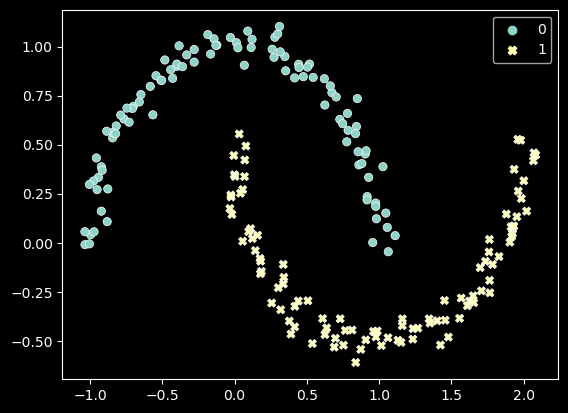

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

We need to be consistent with the chosen device.

In [3]:
from sklearn.metrics import accuracy_score, f1_score
X_train, y_train = make_moons(n_samples=8000, noise=0.2)
X_test, y_test = make_moons(n_samples=200, noise=0.2)

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
testing_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = nn.CrossEntropyLoss()

In [4]:
results_pd = train_network(model, f_loss, training_loader, test_loader=testing_loader, optimizer = optimizer, 
                           epochs=5, device=device, score_funcs={'Acc': accuracy_score, 'F1': f1_score},
                           checkpoint_file='model.pt', disable_tqdm=False )
results_pd

Epoch: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,4.289337,0.349328,0.287871,0.844125,0.875,0.844222,0.878049
1,1,4.630877,0.278364,0.300055,0.879500,0.875,0.879650,0.879227
2,2,4.924708,0.248342,0.248024,0.894500,0.900,0.894711,0.901961
3,3,5.188281,0.193264,0.176505,0.922000,0.940,0.921980,0.940594
4,4,5.463025,0.135101,0.152847,0.950875,0.955,0.950942,0.955224


<Axes: xlabel='total time', ylabel='train Acc'>

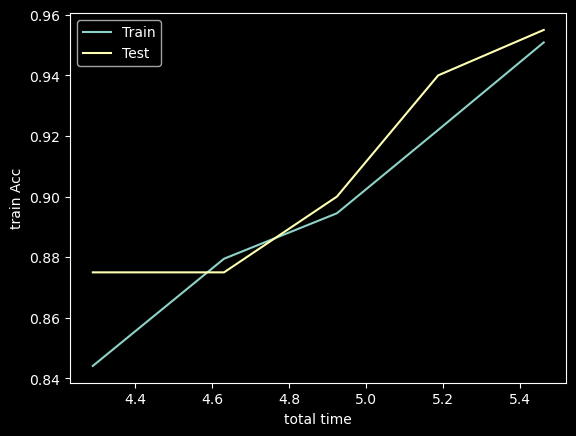

In [5]:
sns.lineplot(x='total time', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='Test')

In [8]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

#if we want to continue training with a new instance of the model, we need a new
#optimizer targeting the parameters of that new model instance. also, ESSENTIAL:
# https://stackoverflow.com/questions/66091226/runtimeerror-expected-all-tensors-to-be-on-the-same-device-but-found-at-least
# https://discuss.pytorch.org/t/code-that-loads-sgd-fails-to-load-adam-state-to-gpu/61783/5?u=shaibagon
optimizer_new = torch.optim.AdamW(model_new.parameters())

In [9]:
visualize2DSoftmax(X_test, y_test, model_new, title="InitialModel")

In [10]:
checkpoint_dict = torch.load('model.pt', map_location=device)

model_new.load_state_dict(checkpoint_dict['model_state_dict'])
optimizer_new.load_state_dict(checkpoint_dict['optimizer_state_dict'])

visualize2DSoftmax(X_test, y_test, model_new)

RuntimeError: Error(s) in loading state_dict for Sequential:
	size mismatch for 0.weight: copying a param with shape torch.Size([30, 2]) from checkpoint, the shape in current model is torch.Size([30, 1]).

In [ ]:
results_pd = train_network(model_new, f_loss, training_loader, test_loader=testing_loader, optimizer = optimizer_new, 
                           epochs=10, device=device, score_funcs={'Acc': accuracy_score, 'F1': f1_score},
                           checkpoint_file='model_new.pt' )
results_pd

Epoch: 100%|██████████| 10/10 [00:13<00:00,  1.35s/it]


,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,1.130065,0.114268,0.101811,0.959750,0.955,0.959790,0.956098
1,1,2.368128,0.098738,0.074848,0.966000,0.975,0.966000,0.975124
2,2,3.655662,0.093520,0.070969,0.965625,0.970,0.965672,0.970297
3,3,4.928906,0.090110,0.069400,0.966875,0.965,0.966970,0.964467
4,4,6.242079,0.088993,0.061145,0.967625,0.970,0.967653,0.970000
5,5,7.592664,0.086425,0.063064,0.966750,0.975,0.966808,0.975369
6,6,8.924296,0.085992,0.074107,0.968875,0.970,0.968925,0.970588
7,7,10.326130,0.085329,0.053041,0.967750,0.980,0.967782,0.980198
8,8,11.757813,0.085651,0.062644,0.967500,0.980,0.967581,0.980198
9,9,13.264186,0.084268,0.054750,0.970000,0.980,0.970052,0.980000


<Axes: xlabel='total time', ylabel='train Acc'>

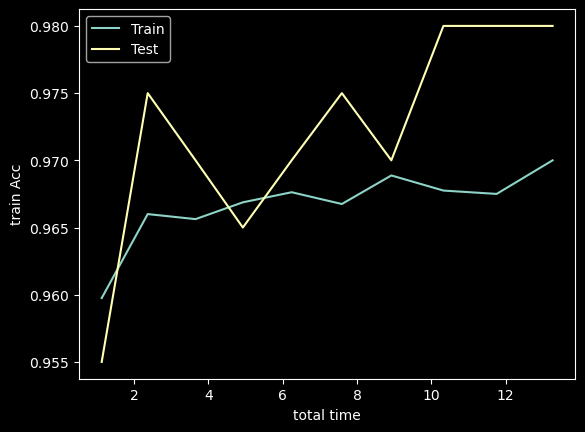

In [ ]:
sns.lineplot(x='total time', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='Test')